# Time Series Forecasting 
## Forecast Retail data using ML Algorithms (XGBoost, Random Forest and Prophet)

Dataset from UCL Retail data: https://archive.ics.uci.edu/ml/datasets/Online+Retail

I am considering the daily total sales as the y or target variable.
Input is the date or in the supervised learning the total sales for the previous days. (depending on how many lags will be given to predict the next day sales.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import datetime as dt
from sklearn import metrics
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
def inverse_stationarity(data, first_value):
    p_i=data.copy()
    p_i=np.insert(p_i,0,first_value) # insert fist value
    p_i=np.cumsum(p_i)
    p_i=np.delete(p_i,0) # remove the first value after calculating cummulative
    p_i=np.exp(p_i) # if you use log 10 then use np.power(10, p_i)
    return p_i


def MAPE(y_actual, y_pred): 
    return np.mean(np.abs((y_actual - y_pred) / y_actual))

## 1. Data preperation

In [3]:
# Initialize columns of dataframe
cols = ["InvoiceNo", "StockCode", "Description", "Quantity", "InvoiceDate", "UnitPrice","CustomerID", "Country"]
keep_cols = ["InvoiceDate", "Quantity", "UnitPrice"]

# read data file
df = (
    pd.read_excel("data/OnlineRetail.xlsx", skiprows=0, header=0, names=cols)
    .drop(columns=[col for col in cols if col not in keep_cols]) # Only keep column keep_cols list
)

df=df.loc[df['InvoiceDate']<'12-01-2011'] # remove last month data

In [4]:
df

,Quantity,InvoiceDate,UnitPrice
0,6,2010-12-01 08:26:00,2.55
1,6,2010-12-01 08:26:00,3.39
2,8,2010-12-01 08:26:00,2.75
3,6,2010-12-01 08:26:00,3.39
4,6,2010-12-01 08:26:00,3.39
...,...,...,...
516379,-1,2011-11-30 17:39:00,0.85
516380,-1,2011-11-30 17:39:00,3.29
516381,-1,2011-11-30 17:42:00,1.25
516382,-1,2011-11-30 17:42:00,7.95


In [5]:
df['TotalPrice']=df['Quantity'].values.astype(int)*df['UnitPrice'].values.astype(float)

In [6]:
df.InvoiceDate=pd.to_datetime(df.InvoiceDate.astype(str).str[0:4] + '-' + df.InvoiceDate.astype(str).str[5:7] + '-' + df.InvoiceDate.astype(str).str[8:10])


In [7]:
daily_cost = df.groupby(['InvoiceDate']).sum()
daily_cost

,Quantity,UnitPrice,TotalPrice
InvoiceDate,,,
2010-12-01,26814,12904.25,58635.56
2010-12-02,21023,6815.68,46207.28
2010-12-03,14830,11114.09,45620.46
2010-12-05,16395,7893.17,31383.95
2010-12-06,21419,17678.78,53860.18
...,...,...,...
2011-11-25,31026,14484.61,50442.72
2011-11-27,11161,6497.72,20571.50
2011-11-28,28647,13875.51,55442.02


In [8]:
daily_cost = daily_cost.reset_index(level=0)

In [9]:
daily_cost['log_tp'] = np.log(daily_cost.TotalPrice)
daily_cost['log_tp_diff'] = daily_cost.log_tp-daily_cost.log_tp.shift()
first_ref_log_tp=daily_cost['log_tp'][0]
daily_cost['log_tp_diff_lag_2'] = daily_cost.log_tp_diff.shift(2)
daily_cost['log_tp_diff_lag_1'] = daily_cost.log_tp_diff.shift(1)
daily_cost

/Users/thilani/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,InvoiceDate,Quantity,UnitPrice,TotalPrice,log_tp,log_tp_diff,log_tp_diff_lag_2,log_tp_diff_lag_1
0,2010-12-01,26814,12904.25,58635.56,10.979097,NaN,NaN,NaN
1,2010-12-02,21023,6815.68,46207.28,10.740893,-0.238204,NaN,NaN
2,2010-12-03,14830,11114.09,45620.46,10.728112,-0.012781,NaN,-0.238204
3,2010-12-05,16395,7893.17,31383.95,10.354052,-0.374060,-0.238204,-0.012781
4,2010-12-06,21419,17678.78,53860.18,10.894147,0.540095,-0.012781,-0.374060
...,...,...,...,...,...,...,...,...
292,2011-11-25,31026,14484.61,50442.72,10.828594,0.047966,0.230774,-0.489981
293,2011-11-27,11161,6497.72,20571.50,9.931662,-0.896932,-0.489981,0.047966
294,2011-11-28,28647,13875.51,55442.02,10.923093,0.991431,0.047966,-0.896932
295,2011-11-29,30511,18797.66,72219.20,11.187461,0.264368,-0.896932,0.991431


In [10]:
df1=daily_cost

# 2. Visualize the data

<AxesSubplot:xlabel='InvoiceDate', ylabel='TotalPrice'>

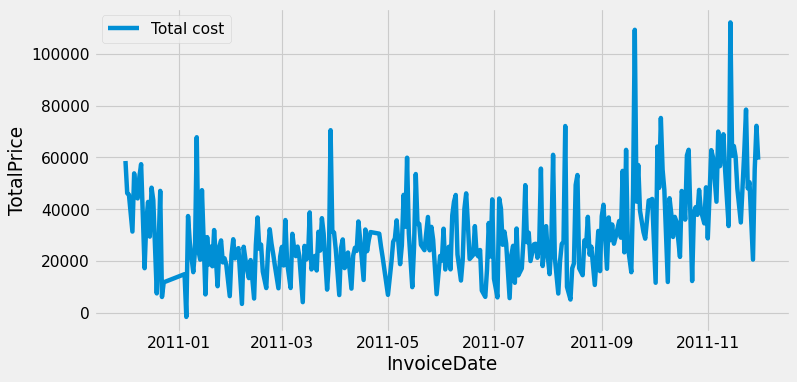

In [11]:
plt.figure(figsize=(10, 5), dpi=80)
sns.lineplot(x='InvoiceDate', y='TotalPrice', data=df1, label='Total cost')

# 3. Create the Model

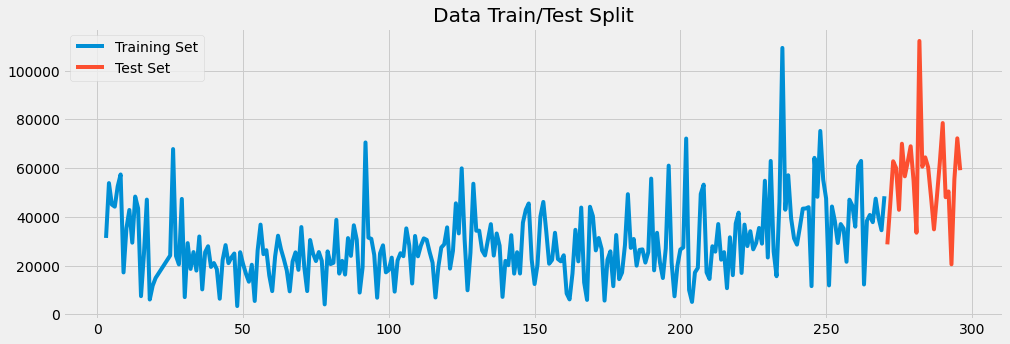

In [12]:
# train / test split
train = df1[df1.InvoiceDate < '11-01-2011'] # 11 months
test = df1[df1.InvoiceDate >= '11-01-2011'] # 1 month

train=train.dropna()

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', y='TotalPrice')
test.plot(ax=ax, label='Test Set', y='TotalPrice')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [13]:
features = ['log_tp_diff_lag_2', 'log_tp_diff_lag_1']
target=['log_tp_diff']
# For a supervised learning regression using XGB or RF, we need to have x lags data to predict the next value.

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

## 3.1 XGBoost

In [14]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=2000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01,
                       colsample_bytree=1,
                       subsample=0.7)
 
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:0.87624	validation_1-rmse:0.67298
[100]	validation_0-rmse:0.59527	validation_1-rmse:0.38661
[200]	validation_0-rmse:0.51822	validation_1-rmse:0.34399
[249]	validation_0-rmse:0.50081	validation_1-rmse:0.34673


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [15]:
y_xgbpredict = reg.predict(X_test)
y_xgbpredict_inverse = inverse_stationarity(y_xgbpredict, train['log_tp'].iloc[-1]) # take inverse of the predicted diff
# Evaluating the Algorithm
print('Mean Absolute Error:', metrics.mean_absolute_error(test.TotalPrice,y_xgbpredict_inverse))
print('Mean Squared Error:', metrics.mean_squared_error(test.TotalPrice,y_xgbpredict_inverse))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test.TotalPrice, y_xgbpredict_inverse)))

Mean Absolute Error: 16180.741685697089
Mean Squared Error: 457627415.2551563
Root Mean Squared Error: 21392.22791705334


In [16]:
print('Accumulated difference to last month Total sales: ', np.sum(test.TotalPrice-y_xgbpredict_inverse))

Accumulated difference to last month Total sales:  182383.91601562395


In [17]:
print(reg.feature_importances_)

[0.38886818 0.61113185]


## 3.2 Random Forest

In [18]:
regrf = RandomForestRegressor(n_estimators=2000, random_state=10, criterion='mae', min_samples_leaf= 3, max_depth=3)
regrf.fit(X_train, y_train)

<ipython-input-18-4b941f9937a3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regrf.fit(X_train, y_train)


RandomForestRegressor(criterion='mae', max_depth=3, min_samples_leaf=3,
                      n_estimators=2000, random_state=10)

In [19]:
# Predicting the Test set results
y_pred = regrf.predict(X_test)  # predict for test set
y_rfpredict_inverse = inverse_stationarity(y_pred, train['log_tp'].iloc[-1]) # take inverse of the predicted diff
# Evaluating the Algorithm
print('Mean Absolute Error:', metrics.mean_absolute_error(test.TotalPrice, y_rfpredict_inverse))
print('Mean Squared Error:', metrics.mean_squared_error(test.TotalPrice, y_rfpredict_inverse))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test.TotalPrice, y_rfpredict_inverse)))

Mean Absolute Error: 27409.47969486037
Mean Squared Error: 1020329508.7269711
Root Mean Squared Error: 31942.59708801041


In [20]:
print('Accumulated difference to last month Total sales: ', np.sum(test.TotalPrice-y_rfpredict_inverse))

Accumulated difference to last month Total sales:  680669.4557995417


## 3.3 Prophet

In [21]:
# prophet need ds, y
prophet_df=df1[['InvoiceDate', 'TotalPrice']].rename(columns={'InvoiceDate':'ds','TotalPrice':'y'})
model=Prophet()
model.fit(prophet_df)

20:54:39 - cmdstanpy - INFO - Chain [1] start processing
20:54:39 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# calculate rmse
cutoffs = pd.to_datetime(['2011-10-31']) # train data up to xx.xx.xx
df_cv2 = cross_validation(model, cutoffs=cutoffs, horizon='30 days') # test data last month
df_p = performance_metrics(df_cv2)
print('Mean Absolute Error:', df_p['mae'].mean())  
print('Mean Squared Error:', df_p['mse'].mean())  
print('Root Mean Squared Error:', df_p['rmse'].mean())

20:54:39 - cmdstanpy - INFO - Chain [1] start processing
20:54:39 - cmdstanpy - INFO - Chain [1] done processing



Mean Absolute Error: 16238.473012097495
Mean Squared Error: 444034172.92990386
Root Mean Squared Error: 17942.855896776946


In [23]:
print('Accumulated difference to last month Total sales: ', np.sum(test.TotalPrice.values-df_cv2.yhat.values))

Accumulated difference to last month Total sales:  363979.0588790106


# 4. Model accuracy

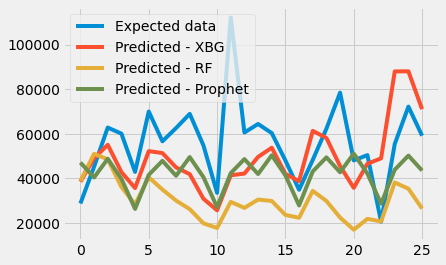

In [24]:
# plot expected vs preducted
plt.plot(test.TotalPrice.tolist(), label='Expected data')
plt.plot(y_xgbpredict_inverse, label='Predicted - XBG')
plt.plot(y_rfpredict_inverse, label='Predicted - RF')
plt.plot(df_cv2.yhat, label='Predicted - Prophet')
plt.legend()
plt.show()